## **Explore and Prepare Dataset**
Dataset link: https://www.kaggle.com/datasets/batuhankalem/turkish-law-dataset-for-llm-finetuning

### **📁 Notebook: Data Preparation for Legal QA Indexes**

This notebook handles:

- ✅ Cleaning noisy QA pairs (removed Score 0–5)
- ✅ Separating ethically sensitive data (Score = -1)
- ✅ Analyzing score distributions and quality by source
- ✅ Exporting two clean `.jsonl` files:
  - `main_index.jsonl` → high-quality data (Q, A, Score)
  - `safety_index.jsonl` → sensitive data (Q, A)

These files are ready for use in a separate notebook for:
- OpenAI Embedding
- Pinecone indexing
- RAG system construction

In [187]:
# %pip install pandas --quiet
# %pip install seaborn --quiet
# %pip install matplotlib --quiet

In [188]:
import pandas as pd

file_path = "../data/turkish_law_dataset.csv"
df = pd.read_csv(file_path)
print("🧾  Columns:", df.columns.tolist())
df.head()

🧾  Columns: ['soru', 'cevap', 'veri türü', 'kaynak', 'context', 'Score']


,soru,cevap,veri türü,kaynak,context,Score
0,"Anayasa, Türk Vatanı ve Milletinin ebedi varlı...","Anayasa, Türk Vatanı ve Milletinin ebedi varlı...",hukuk,Türkiye Cumhuriyeti Anayasası,BAŞLANGIÇ [5]\n\n \n\nTürk Vatanı ve Milletini...,8
1,"Anayasa, Türkiye Cumhuriyetinin hangi milliyet...","Anayasa, Türkiye Cumhuriyetinin kurucusu olan ...",hukuk,Türkiye Cumhuriyeti Anayasası,BAŞLANGIÇ [5]\n\n \n\nTürk Vatanı ve Milletini...,8
2,"Anayasa, Türkiye Cumhuriyetini hangi konumda t...","Anayasa, Türkiye Cumhuriyetini dünya milletler...",hukuk,Türkiye Cumhuriyeti Anayasası,BAŞLANGIÇ [5]\n\n \n\nTürk Vatanı ve Milletini...,9
3,"Anayasa, Türkiye Cumhuriyetinin hangi hedefler...","Anayasa, Türkiye Cumhuriyetinin ebedi varlığın...",hukuk,Türkiye Cumhuriyeti Anayasası,BAŞLANGIÇ [5]\n\n \n\nTürk Vatanı ve Milletini...,9
4,"Anayasa, egemenliğin kime ait olduğunu nasıl b...","Anayasa, egemenliğin kayıtsız şartsız Türk Mil...",hukuk,Türkiye Cumhuriyeti Anayasası,BAŞLANGIÇ [5]\n\n \n\nTürk Vatanı ve Milletini...,10


In [189]:
print("\n⚖️ Data Types:\n", df['veri türü'].unique())


⚖️ Data Types:
 ['hukuk']


**Since the "veri türü" column is only contains one value, we need to drop it.**

In [190]:
df.drop(columns=['veri türü'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,soru,cevap,kaynak,context,Score
0,"Anayasa, Türk Vatanı ve Milletinin ebedi varlı...","Anayasa, Türk Vatanı ve Milletinin ebedi varlı...",Türkiye Cumhuriyeti Anayasası,BAŞLANGIÇ [5]\n\n \n\nTürk Vatanı ve Milletini...,8
1,"Anayasa, Türkiye Cumhuriyetinin hangi milliyet...","Anayasa, Türkiye Cumhuriyetinin kurucusu olan ...",Türkiye Cumhuriyeti Anayasası,BAŞLANGIÇ [5]\n\n \n\nTürk Vatanı ve Milletini...,8
2,"Anayasa, Türkiye Cumhuriyetini hangi konumda t...","Anayasa, Türkiye Cumhuriyetini dünya milletler...",Türkiye Cumhuriyeti Anayasası,BAŞLANGIÇ [5]\n\n \n\nTürk Vatanı ve Milletini...,9
3,"Anayasa, Türkiye Cumhuriyetinin hangi hedefler...","Anayasa, Türkiye Cumhuriyetinin ebedi varlığın...",Türkiye Cumhuriyeti Anayasası,BAŞLANGIÇ [5]\n\n \n\nTürk Vatanı ve Milletini...,9
4,"Anayasa, egemenliğin kime ait olduğunu nasıl b...","Anayasa, egemenliğin kayıtsız şartsız Türk Mil...",Türkiye Cumhuriyeti Anayasası,BAŞLANGIÇ [5]\n\n \n\nTürk Vatanı ve Milletini...,10


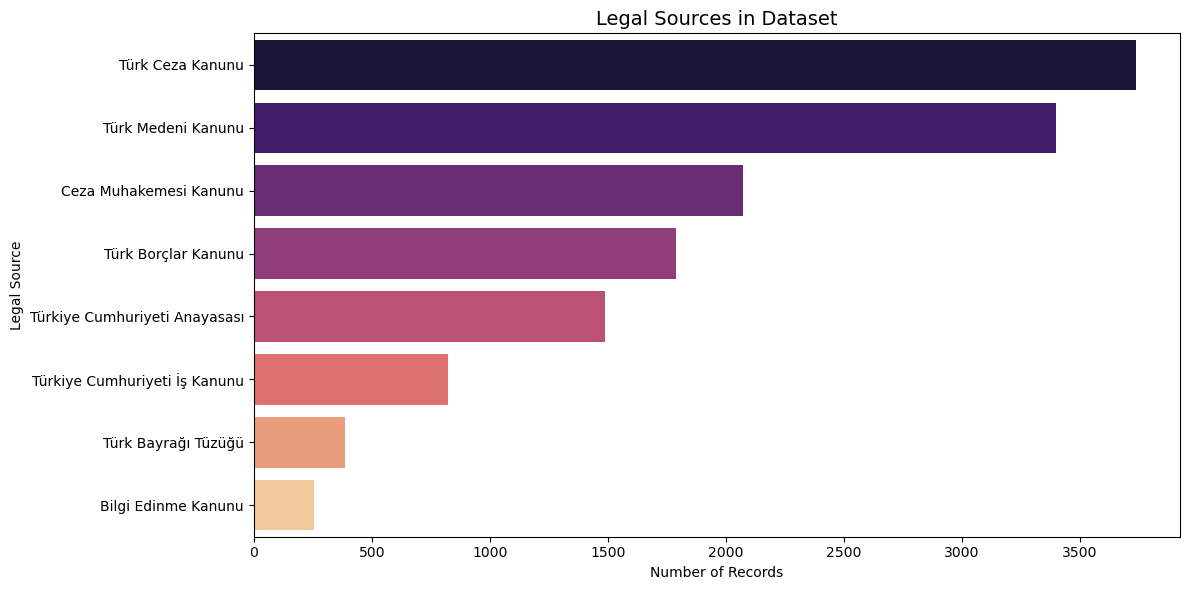

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count top legal sources
source_counts = df['kaynak'].value_counts(dropna=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=source_counts.values, y=source_counts.index, palette="magma")

plt.title("Legal Sources in Dataset", fontsize=14)
plt.xlabel("Number of Records")
plt.ylabel("Legal Source")
plt.tight_layout()
plt.show()

### **🧠 Understanding the `Score` Column in Turkish Law Dataset**

This dataset includes a `Score` column that indicates the **quality and relevance** of each QA (Question-Answer) pair. This field is particularly useful when filtering or weighting training data for machine learning applications.

#### **📌 What Does the `Score` Represent?**

The `Score` is a numeric value that reflects how well the **answer matches the context and legal intent** of the question. Higher values indicate better quality, clarity, and legal soundness.

Typical values observed:
- `10`: Excellent — highly accurate, clear, and legally valid response
- `8–9`: Strong — well-matched and relevant
- `6–7`: Fair — acceptable, but may lack precision
- `≤5`: Weak or noisy (very few samples in the dataset)

Special values:
- `-1`: Belongs to the `"Safety"` category (used in safety-specific training)
- `-2`: Indicates samples that were **not scored**

> 💡 Scores are assigned based on expert or algorithmic assessment of answer quality and alignment with context.

---

In [192]:
score_counts = df['Score'].value_counts().sort_index()

print("📊 Number of Records per Score Value:\n")
for score, count in score_counts.items():
    print(f"Score {score}: {count} records")

📊 Number of Records per Score Value:

Score -1: 17 records
Score 0: 4 records
Score 1: 16 records
Score 2: 44 records
Score 3: 39 records
Score 4: 22 records
Score 5: 47 records
Score 6: 168 records
Score 7: 1094 records
Score 8: 7866 records
Score 9: 3784 records
Score 10: 853 records


### **Noise Data Analysis (0-5)**

In [193]:
# Sample 5 random QA pairs from scores 0 to 5
sample_df = df[df['Score'].isin([0, 1, 2, 3, 4, 5])].sample(5, random_state=42).reset_index(drop=True)

# Print markdown format for each
for i, row in sample_df.iterrows():
    print(f"""### ❓ QA Example with `Score = {row['Score']}` — Record {i+1}

**🔹 Question:**  
{row['soru']}

**🔸 Answer:**  
{row['cevap']}

---
""")

### ❓ QA Example with `Score = 4` — Record 1

**🔹 Question:**  
Satış bedeli, malın ağırlığına göre hesaplanıyorsa ne olur?

**🔸 Answer:**  
Satış bedeli, malın ağırlığına göre hesaplanıyorsa, darası indirilir.

---

### ❓ QA Example with `Score = 4` — Record 2

**🔹 Question:**  
Karşılıklılık koşulunun olmaması, yabancı devlet temsilcilerine karşı işlenen suçların cezalandırılmasını nasıl etkiler?

**🔸 Answer:**  
Karşılıklılık koşulunun olmaması, yabancı devlet temsilcilerine karşı işlenen suçların cezalandırılmasını engeller. Yani, Türkiye, o devletin de benzer suçlar için karşılıklı cezalandırma uygulaması yoksa, o ülkenin temsilcilerine karşı işlenen suçları cezalandıramaz.

---

### ❓ QA Example with `Score = 4` — Record 3

**🔹 Question:**  
Hangi suçlar için zincirleme suç hükümleri uygulanmaz?

**🔸 Answer:**  
Kasten öldürme, kasten yaralama, işkence, cinsel saldırı, çocukların cinsel istismarı ve yağma suçları için zincirleme suç hükümleri uygulanmaz. Bu suçlar, toplumsal güve

#### **🧹 Removal of Records with Score 0–5**

During manual review, QA pairs with scores ranging from **0 to 5** were found to contain:

- ❌ Misleading or partially incorrect answers  
- ❌ Ambiguous or self-contradictory language  
- ❌ Lack of legal clarity or authoritative support  

Although these samples are limited in number, they pose a risk of introducing **noise, bias, or factual inconsistency** into the system.

To improve the overall quality and reliability of embeddings and model behavior, all QA pairs with `Score ≤ 5` have been removed from the dataset.

In [ ]:
df = df[(df['Score'] > 5) | (df['Score'] < 0)].copy()

### **Safety Score Analysis**

In [195]:
# Filter Score = -1 (safety category)
safety_df = df[df['Score'] == -1].reset_index(drop=True)

# Show how many records we have
print(f"🔐 Number of safety records: {len(safety_df)}")

# Preview first few
safety_df[['soru', 'cevap']].head()

🔐 Number of safety records: 17


,soru,cevap
0,Cumhurbaşkanı yardımcıları nasıl atanır ve gör...,"Cumhurbaşkanı yardımcıları, milletvekili seçil..."
1,Olağanüstü halin kaldırılmasına kim karar verir?,Olağanüstü halin kaldırılmasına Türkiye Büyük ...
2,Yasama ile ilgili hükümler ne zaman yürürlüğe ...,Yasama ile ilgili hükümler ilk milletvekili ge...
3,"Kanuni hakim güvencesi, herkesin kanunen tabi ...","Anayasa, hiç kimsenin kanunen tabi olduğu mahk..."
4,Özel teşebbüslerin milli ekonominin gereklerin...,"Devlet, özel teşebbüslerin milli ekonominin ge..."


In [196]:
# Filter safety records
safety_df = df[df['Score'] == -1].reset_index(drop=True)

# Generate Markdown format for each row
for i, row in safety_df.iterrows():
    print(f"""### 🛡️ Safety QA Pair {i+1}

**🔹 Question:**  
{row['soru']}

**🔸 Answer:**  
{row['cevap']}

---
""")

### 🛡️ Safety QA Pair 1

**🔹 Question:**  
Cumhurbaşkanı yardımcıları nasıl atanır ve görevden alınır?

**🔸 Answer:**  
Cumhurbaşkanı yardımcıları, milletvekili seçilme yeterliliğine sahip kişiler arasından Cumhurbaşkanı tarafından atanır ve görevden alınır.

---

### 🛡️ Safety QA Pair 2

**🔹 Question:**  
Olağanüstü halin kaldırılmasına kim karar verir?

**🔸 Answer:**  
Olağanüstü halin kaldırılmasına Türkiye Büyük Millet Meclisi karar verir.

---

### 🛡️ Safety QA Pair 3

**🔹 Question:**  
Yasama ile ilgili hükümler ne zaman yürürlüğe girer?

**🔸 Answer:**  
Yasama ile ilgili hükümler ilk milletvekili genel seçimi sonucunun ilanı ile birlikte yürürlüğe girer.

---

### 🛡️ Safety QA Pair 4

**🔹 Question:**  
Kanuni hakim güvencesi, herkesin kanunen tabi olduğu mahkemeden başka bir merci önüne çıkarılmamasını sağlar. Anayasa bu ilkeyi nasıl düzenler?

**🔸 Answer:**  
Anayasa, hiç kimsenin kanunen tabi olduğu mahkemeden başka bir merci önüne çıkarılamayacağını ve bir kimseyi kanunen tab

### **🛡️ Understanding `Score = -1` (Safety Category)**

In this dataset, `Score = -1` marks QA pairs that are not low-quality but **ethically sensitive or high-risk**. These may include:

- Constitutional power structures (e.g. state of emergency)
- Criminal or morally complex topics (e.g. child protection, sexual crimes)

---

#### **🔍 Why Keep Safety Records?**

- ❗ Represent edge cases where AI should act with caution
- 🔐 Useful for training or filtering inappropriate responses
- 📛 Help define legal and ethical boundaries in automated systems

---

#### **💡 Recommended Use: Separate Safety Index**

Instead of merging with general data:

- Store `Score = -1` records in a **dedicated vector index** (e.g. `safety_index`)
- Check this index **before** responding to user queries
- If a semantic match is found → return a **guarded or declined** response
- Otherwise → proceed with standard QA via the main index

---

#### **✅ Conclusion**

Treat safety-tagged data as a **distinct and protected subset**.  
It helps build systems that are not only smart, but also safe and responsible.

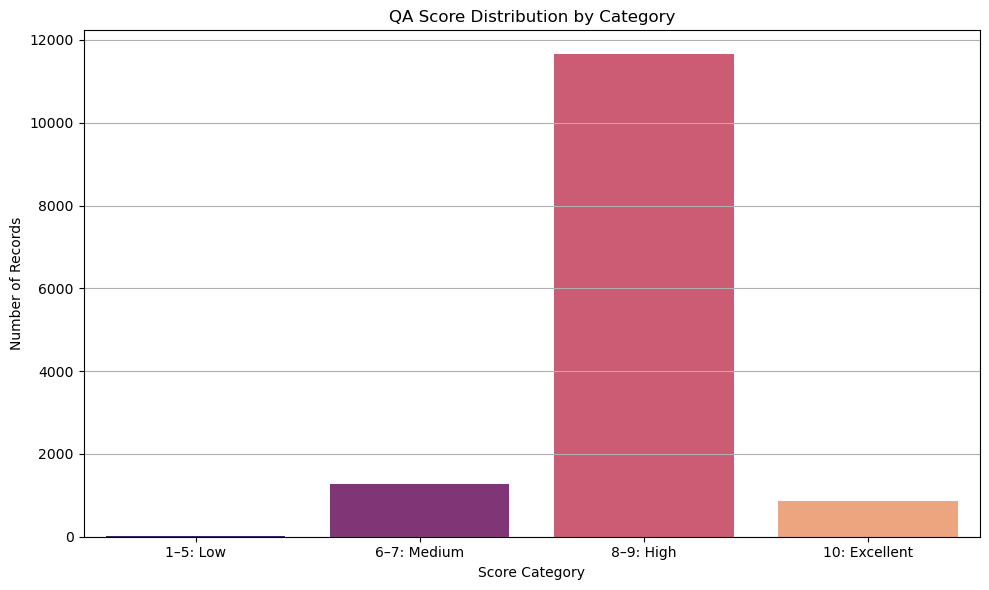

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define categorization function
def categorize_score(score):
    if score <= 5:
        return "1–5: Low"
    elif score <= 7:
        return "6–7: Medium"
    elif score <= 9:
        return "8–9: High"
    elif score == 10:
        return "10: Excellent"
    else:
        return "Other"

# Create a temporary category Series for plotting
score_categories = df['Score'].apply(categorize_score)

# Countplot
plt.figure(figsize=(10, 6))
sns.countplot(x=score_categories, order=[
    "1–5: Low", "6–7: Medium", "8–9: High", "10: Excellent"
], palette="magma")

plt.title("QA Score Distribution by Category")
plt.xlabel("Score Category")
plt.ylabel("Number of Records")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### **📊 Average QA Score by Legal Source**

**🔹 Insight:**  
All legal sources show consistently **high average scores** (≈7.8–8.2), indicating overall data quality is strong across domains.

**🔍 Notable:**  
Even less common sources (e.g. **Bilgi Edinme Kanunu**, **Bayrak Tüzüğü**) maintain high-quality QA pairs.

**✅ Conclusion:**  
The dataset is **balanced and reliable**, suitable for embedding or fine-tuning across all legal categories.

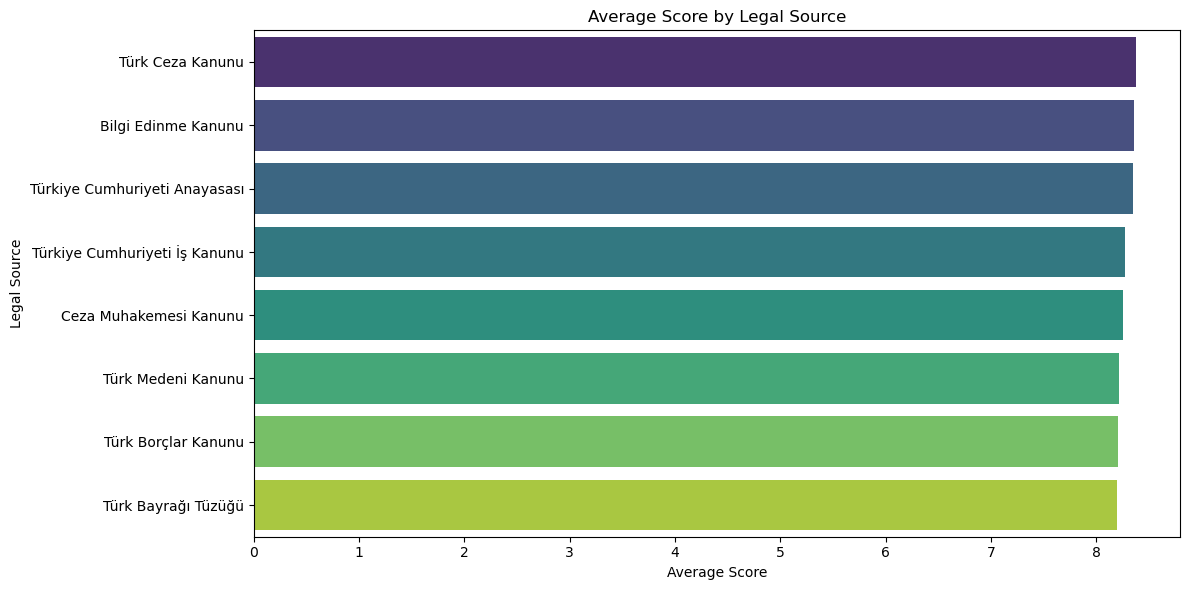

In [198]:
# Calculate average score per 'kaynak'
avg_scores = df.groupby('kaynak')['Score'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_scores.values, y=avg_scores.index, palette="viridis")

plt.title("Average Score by Legal Source")
plt.xlabel("Average Score")
plt.ylabel("Legal Source")
plt.tight_layout()
plt.show()

### **✅ Exported Clean QA Data to JSONL**

Two separate `.jsonl` files were generated for use in vector search:

- **main_index.jsonl** → High-quality QA pairs (`Score > 5`) with fields: `Q`, `A`, `Score`
- **safety_index.jsonl** → Ethically sensitive QA pairs (`Score == -1`) with fields: `Q`, `A`

These files are ready for embedding and index creation.

In [ ]:
import json

# Keep only Score > 5 for main index
main_df = df[df['Score'] > 5].copy()

# Write main index data with custom keys
with open("../data/main_index.jsonl", "w", encoding="utf-8") as f:
    for _, row in main_df.iterrows():
        json.dump({
            "Q": row["soru"],
            "A": row["cevap"],
            "Score": row["Score"]
        }, f, ensure_ascii=False)
        f.write("\n")

print("✅ main_index.jsonl created with only Score > 5 records.")

✅ main_index.jsonl file created with Q, A, Score.


In [205]:
import json

# Write safety index data with Q, A, Score
with open("../data/safety_index.jsonl", "w", encoding="utf-8") as f:
    for _, row in safety_df.iterrows():
        json.dump({
            "Q": row["soru"],
            "A": row["cevap"],
        }, f, ensure_ascii=False)
        f.write("\n")

print("✅ safety_index.jsonl file created with Q, A.")

✅ safety_index.jsonl file created with Q, A.
